# Introduction
This project aims to draw the connection between transportation crashes occurred in the city of Philadelphia and the weather forecasts in the same area. The hypothesis is that inclement weather lead to higher traffic accidents in certain areas of the city.

# Data Preprocessing
## Import libraries

In [154]:
import requests
import json
import pandas as pd
from datetime import datetime   
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

# Format and style
%matplotlib inline
plt.style.use(u'fivethirtyeight')

## Dataset 1


This dataset contains all crashes resulting in an injury in the City of San Francisco. Fatality year-to-date crash data is obtained from the Office of the Chief Medical Examiner (OME) death records, and only includes those cases that meet the San Francisco Vision Zero Fatality Protocol maintained by the San Francisco Department of Public Health (SFDPH), San Francisco Police Department (SFPD), and San Francisco Municipal Transportation Agency (SFMTA). Injury crash data is obtained from SFPD’s Interim Collision System for 2018 through the current year-to-date, Crossroads Software Traffic Collision Database (CR) for years 2013-2017 and the Statewide Integrated Transportation Record System (SWITRS) maintained by the California Highway Patrol for all years prior to 2013. Only crashes with valid geographic information are mapped. All geocodable crash data is represented on the simplified San Francisco street centerline model maintained by the Department of Public Works (SFDPW). Collision injury data is queried and aggregated on a quarterly basis. Crashes occurring at complex intersections with multiple roadways are mapped onto a single point and injury and fatality crashes occurring on highways are excluded.



Additional information: https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx

In [4]:
Collision_API1 = "https://data.sfgov.org/resource/ubvf-ztfx.json"
resp1 = requests.get(Collision_API1)

# We transform the returned JSON answer from the API into a Python dictionary object
results = json.loads(resp1.text)

#create dataframe from list of dictionary
df = pd.DataFrame(results)

#View available columns
df.columns

Index(['id', 'unique_id', 'cnn_intrsctn_fkey', 'cnn_sgmt_fkey', 'case_id_pkey',
       'tb_latitude', 'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_description',
       'number_killed', 'number_injured', 'street_view', 'dph_col_grp',
       'dph_col_grp_description', 'party1_type', 'party1_dir_of_travel',
       'party1_move_pre_acc', 'point', 'data_loaded_at',
       ':@computed_region_jwn9_ihcz', ':@computed_region_6qbp_sg9q',
       ':@computed_region_qgnn_b9vv', ':@computed_region_26cr_cadq',
       ':

In [5]:
#identify collumns with too much null values
missing_percentages = df.isna().sum().sort_values(ascending = False)/len(df)

#sort out the ones with zeroes
missing_percentages[missing_percentages != 0]

cnn_sgmt_fkey                  0.546
party_at_fault                 0.138
party2_move_pre_acc            0.128
party2_dir_of_travel           0.128
party2_type                    0.128
beat_number                    0.090
reporting_district             0.085
weather_2                      0.031
vz_pcf_link                    0.025
officer_id                     0.021
:@computed_region_6qbp_sg9q    0.017
:@computed_region_jwn9_ihcz    0.017
:@computed_region_ajp5_b2md    0.011
:@computed_region_qgnn_b9vv    0.011
:@computed_region_26cr_cadq    0.010
tb_latitude                    0.008
point                          0.008
tb_longitude                   0.008
street_view                    0.007
secondary_rd                   0.005
distance                       0.005
collision_time                 0.003
vz_pcf_group                   0.003
time_cat                       0.003
dtype: float64

In [6]:
#drop unnecessary columns
df0 = df.drop(['cnn_sgmt_fkey',':@computed_region_jwn9_ihcz',
       ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv',
       ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md'],axis=1)

#drop rows with null values in location and time columns
df1 = df0.dropna(subset=['tb_longitude'])
df2 = df1.dropna(subset=['collision_datetime'])


In [7]:
#Limit sample to 500 instances with only necessary columns for analysis with OpenWeather API (1000 calls/day limit)
Collision_sample_1 = df2.sample(n = 501)

#Save sample as CSV file
Collision_sample_1.to_csv('Collision_sample_1.csv')

#Save sample json file
Collision_sample_1.to_json('Collision_sample_1.json',orient='records')

In [81]:
#get crash data/checkpoint
crash = pd.read_csv("Collision_sample_1.csv")
crash1 = json.load(open('Collision_sample_1.json','r'))

In [9]:
#Check 
crash1
print(len(crash1))

501


In [10]:
#Check data null count and types
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               501 non-null    int64  
 1   id                       501 non-null    object 
 2   unique_id                501 non-null    int64  
 3   cnn_intrsctn_fkey        501 non-null    float64
 4   case_id_pkey             501 non-null    int64  
 5   tb_latitude              501 non-null    float64
 6   tb_longitude             501 non-null    float64
 7   geocode_source           501 non-null    object 
 8   geocode_location         501 non-null    object 
 9   collision_datetime       501 non-null    object 
 10  collision_date           501 non-null    object 
 11  collision_time           501 non-null    object 
 12  accident_year            501 non-null    int64  
 13  month                    501 non-null    object 
 14  day_of_week              5

## Dataset 2

Historical weather data provided by OpenWeather allow access to hourly weather data at specific points in time. The dataset will be extracted based on latitude and longitude provided from the crash site dataset 

The documentation for this data is https://openweathermap.org/api/one-call-3#history

In [83]:
#Convert time to UNIX timestamp format
def convert_unix(i):
    datetime_obj = datetime.strptime(i,
                                 "%Y-%m-%dT%H:%M:%S.000")
    unix_time = datetime.timestamp(datetime_obj)
    return unix_time

#insert converted data into json file
 
for i in crash1:
    bi = int(convert_unix(i['collision_datetime']))
    unix_add = {"unix_dict": bi} 
    i.update(unix_add)


In [29]:
query_template = '''https://api.openweathermap.org/data/3.0/onecall/timemachine?lat=%s&lon=%s&dt=%s&appid=%s''' 
API = []
for entry in crash1: 
    lat = entry['tb_latitude'] 
    lon = entry['tb_longitude']
    dt = entry['unix_dict'] 
    appid = "503ed749861a1697a1d7ac5455250b08" 
    query_parameters = (lat, lon, dt, appid) 
    Weather_API = query_template % query_parameters 
    API.append(Weather_API)


In [73]:
#request data
weather_json = []

for link in API:
    weather_data = requests.get(link).json()
    ver1 = weather_data['data'][0]
    ver1.update(weather_data)
    ver1.pop('data')
    ver2 = ver1['weather'][0]
    ver2.update(ver1)
    ver2.pop('weather')
    weather_json.append(ver2)
    time.sleep(1)

In [74]:
#convert to dataframe
results_df = pd.DataFrame(weather_json)
results_df

,id,main,description,icon,dt,sunrise,sunset,temp,feels_like,pressure,...,dew_point,clouds,wind_speed,wind_deg,lat,lon,timezone,timezone_offset,wind_gust,rain
0,800,Clear,clear sky,01d,1364002320,1363961370,1364005396,286.01,285.05,1017,...,279.60,0,5.80,301,37.7638,-122.4264,America/Los_Angeles,-25200,NaN,NaN
1,804,Clouds,overcast clouds,04d,1302738480,1302701831,1302748963,285.06,283.95,1025,...,278.25,94,7.04,281,37.7655,-122.4123,America/Los_Angeles,-25200,NaN,NaN
2,800,Clear,clear sky,01d,1626480600,1626440438,1626492624,286.08,285.73,1012,...,284.14,7,8.05,295,37.7324,-122.4056,America/Los_Angeles,-25200,15.20,NaN
3,801,Clouds,few clouds,02n,1386336600,1386342674,1386377449,277.81,276.59,1021,...,273.39,23,1.59,268,37.7281,-122.4022,America/Los_Angeles,-28800,NaN,NaN
4,801,Clouds,few clouds,02d,1521751740,1521727789,1521771774,285.30,284.53,1012,...,281.01,18,8.80,260,37.7935,-122.3976,America/Los_Angeles,-25200,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,803,Clouds,broken clouds,04d,1631373600,1631368116,1631413446,287.81,287.66,1017,...,286.02,84,1.87,257,37.7738,-122.4240,America/Los_Angeles,-25200,NaN,NaN
497,800,Clear,clear sky,01n,1404365040,1404305515,1404358512,287.81,287.58,1012,...,285.50,1,3.96,257,37.7484,-122.4077,America/Los_Angeles,-25200,NaN,NaN
498,804,Clouds,overcast clouds,04d,1362535200,1362494102,1362535637,284.03,282.64,1012,...,275.61,94,3.08,270,37.7488,-122.4065,America/Los_Angeles,-28800,3.08,NaN
499,804,Clouds,overcast clouds,04n,1515682800,1515684282,1515719422,284.97,284.74,1026,...,284.51,98,1.14,123,37.7200,-122.4383,America/Los_Angeles,-28800,NaN,NaN


In [79]:
#save new dataframe as csv file
results_df.to_csv('Collision_weather.csv') 

#Save sample json file
results_df.to_json('Collision_weather.json',orient='records')

In [82]:
#get crash data/checkpoint
weather = pd.read_csv("Collision_weather.csv")
weather_1 = json.load(open('Collision_weather.json','r'))

## Merge two datasets


In [89]:
#convert crash1 json file back to dataframe for merge
crash1_df = pd.DataFrame(crash1)
crash1_df.to_csv('Collision.csv') 

In [100]:
merge_df = pd.merge(crash1_df, results_df, left_on='unix_dict', right_on='dt')

#save new dataframe as csv file
merge_df.to_csv('Collision_weather_merged.csv')


## Clean Data

In [147]:
merged = pd.read_csv("Collision_weather_merged.csv")

#remove unnecessary columns
merged1 = merged.drop(['unique_id','Unnamed: 0','id_x','case_id_pkey','icon',
       'street_view', 'point', 'id_y',
       'data_loaded_at','vz_pcf_group', 'vz_pcf_link'],axis=1)
merged1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cnn_intrsctn_fkey        501 non-null    float64
 1   tb_latitude              501 non-null    float64
 2   tb_longitude             501 non-null    float64
 3   geocode_source           501 non-null    object 
 4   geocode_location         501 non-null    object 
 5   collision_datetime       501 non-null    object 
 6   collision_date           501 non-null    object 
 7   collision_time           501 non-null    object 
 8   accident_year            501 non-null    int64  
 9   month                    501 non-null    object 
 10  day_of_week              501 non-null    object 
 11  time_cat                 501 non-null    object 
 12  juris                    501 non-null    int64  
 13  officer_id               492 non-null    object 
 14  reporting_district       4

In [246]:
#convert to correct datatypes

#time
merged1["collision_datetime"] = pd.to_datetime(merged1["collision_datetime"], format="%Y-%m-%dT%H:%M:%S")
merged1["collision_date"] = pd.to_datetime(merged1["collision_date"], format="%Y-%m-%d")

#categoricals

merged1["time_cat"] =  pd.Categorical(merged1["time_cat"], ordered=False)
merged1["description"] =  pd.Categorical(merged1["description"], ordered=False)
merged1["collision_severity"] =  pd.Categorical(merged1["collision_severity"], categories = ['Fatal','Injury (Severe)', 'Injury (Complaint of Pain)', 'Injury (Other Visible)'], ordered=True)


In [278]:
#outliers
quantile_99 = merged1.quantile(.99).number_injured
clean_df = merged1[merged1.number_injured < quantile_99]
#keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
clean_df = merged1[np.abs(merged1.number_injured-merged1.number_injured.mean())<=(3*merged1.number_injured.std())]

# Exploratory Data Analysis (EDA)
## Quantitative data summary statistics

In [252]:
clean_df.describe(include=[int])

,accident_year,juris,distance,number_killed,number_injured,unix_dict,dt,sunrise,sunset,pressure,humidity,clouds,wind_deg,timezone_offset
count,497.000000,497.000000,497.000000,497.000000,497.000000,4.970000e+02,4.970000e+02,4.970000e+02,4.970000e+02,497.000000,497.000000,497.000000,497.000000,497.000000
mean,2015.883300,3945.752515,57.408451,0.010060,1.245473,1.462971e+09,1.462971e+09,1.462950e+09,1.462994e+09,1017.026157,77.812877,49.420523,218.790744,-26583.501006
std,4.775026,884.126645,134.153079,0.099896,0.622256,1.510283e+08,1.510283e+08,1.510262e+08,1.510267e+08,4.916779,14.660238,40.088991,93.114180,1752.915031
min,2005.000000,3801.000000,0.000000,0.000000,0.000000,1.104857e+09,1.104857e+09,1.104852e+09,1.104887e+09,1001.000000,22.000000,0.000000,0.000000,-28800.000000
25%,2013.000000,3801.000000,0.000000,0.000000,1.000000,1.368299e+09,1.368299e+09,1.368277e+09,1.368328e+09,1014.000000,71.000000,4.000000,171.000000,-28800.000000
50%,2015.000000,3801.000000,0.000000,0.000000,1.000000,1.434177e+09,1.434177e+09,1.434113e+09,1.434166e+09,1016.000000,80.000000,50.000000,254.000000,-25200.000000
75%,2021.000000,3801.000000,60.000000,0.000000,1.000000,1.632114e+09,1.632114e+09,1.632060e+09,1.632104e+09,1020.000000,89.000000,94.000000,283.000000,-25200.000000
max,2022.000000,9335.000000,1320.000000,1.000000,4.000000,1.656292e+09,1.656292e+09,1.656248e+09,1.656301e+09,1033.000000,100.000000,100.000000,360.000000,-25200.000000


In [253]:
clean_df.describe(include=[float])

,cnn_intrsctn_fkey,tb_latitude,tb_longitude,party_at_fault,temp,feels_like,dew_point,wind_speed,lat,lon,wind_gust
count,4.970000e+02,497.000000,497.000000,423.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,186.000000
mean,2.582798e+07,37.764697,-122.427388,1.014184,286.700101,286.099859,282.588129,2.987907,37.764697,-122.427387,4.336989
std,5.349852e+06,0.025007,0.029046,0.136951,3.701053,4.052331,3.876728,1.941658,0.025007,0.029044,2.638278
min,2.014800e+07,37.708101,-122.513051,1.000000,270.590000,266.500000,264.250000,0.080000,37.708100,-122.513100,0.000000
25%,2.364200e+07,37.744918,-122.439504,1.000000,284.370000,283.710000,280.470000,1.340000,37.744900,-122.439500,2.597500
50%,2.489300e+07,37.772053,-122.420628,1.000000,286.670000,286.250000,283.210000,2.680000,37.772100,-122.420600,3.810000
75%,2.672000e+07,37.783214,-122.407746,1.000000,288.950000,288.610000,285.370000,4.080000,37.783200,-122.407700,5.810000
max,5.436600e+07,37.825146,-122.364481,3.000000,301.150000,299.950000,289.470000,11.150000,37.825100,-122.364500,15.200000


Text(0.5, 1.0, 'Distribution of injuries')

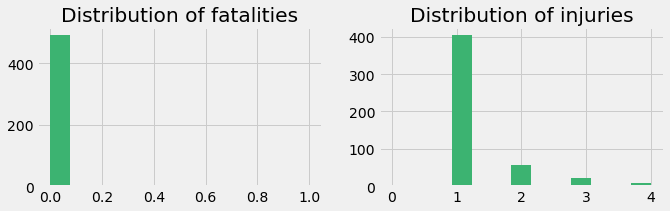

In [283]:
#find best bin size
sturges = lambda n: int(np.log2(n) + 1)
square_root = lambda n: int(np.sqrt(n))
doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))

n = len(clean_df)

fig = plt.figure(figsize=(10,6))

# Create the first subfigure
sub1 = fig.add_subplot(2,2,1)

sturges(n), square_root(n), doanes(clean_df.number_killed.dropna())
clean_df.number_killed.hist(bins=doanes(clean_df.number_killed.dropna()),color = 'mediumseagreen')
plt.title("Distribution of fatalities")

# Create the second subfigure
sub2 = fig.add_subplot(2,2,2)

sturges(n), square_root(n), doanes(clean_df.number_injured.dropna())
clean_df.number_injured.hist(bins=doanes(clean_df.number_killed.dropna()),color = 'mediumseagreen')

plt.title("Distribution of injuries")

Text(0.5, 1.0, 'Distribution of humidity')

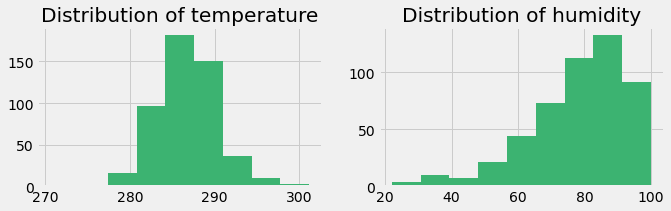

In [284]:
#find best bin size
sturges = lambda n: int(np.log2(n) + 1)
square_root = lambda n: int(np.sqrt(n))
doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))

n = len(clean_df)

fig = plt.figure(figsize=(10,6))

# Create the third subfigure
sub3 = fig.add_subplot(2,2,3)

sturges(n), square_root(n), doanes(clean_df.temp.dropna())
clean_df.temp.hist(bins=doanes(clean_df.temp.dropna()),color = 'mediumseagreen')
plt.title("Distribution of temperature")

# Create the fourth subfigure
sub4 = fig.add_subplot(2,2,4)

sturges(n), square_root(n), doanes(clean_df.humidity.dropna())
clean_df.humidity.hist(bins=doanes(clean_df.humidity.dropna()),color = 'mediumseagreen')
plt.title("Distribution of humidity")

Text(0.5, 1.0, 'Number of injured vs. temparature at time of accident')

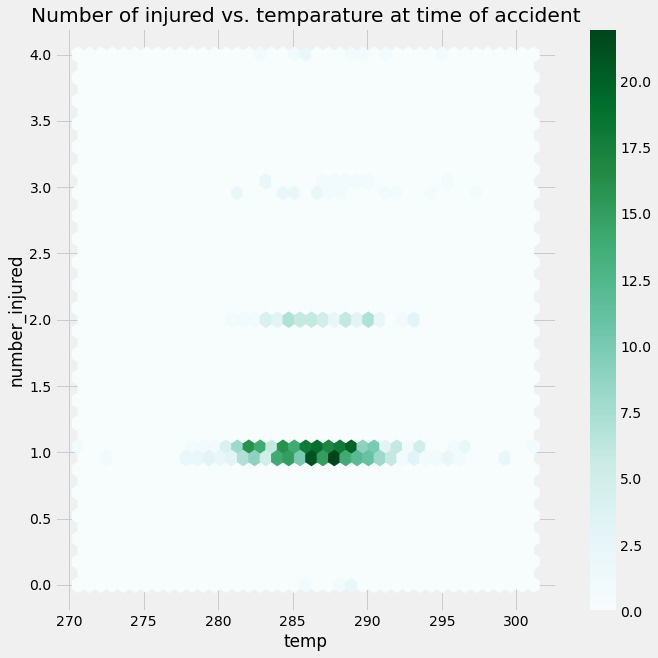

In [264]:
clean_df.plot(kind='hexbin', x='temp', y='number_injured', gridsize=40,figsize=(10,10))
plt.title("Number of injured vs. temparature at time of accident")

Text(0.5, 1.0, 'Number of injured vs. humidity at time of accident')

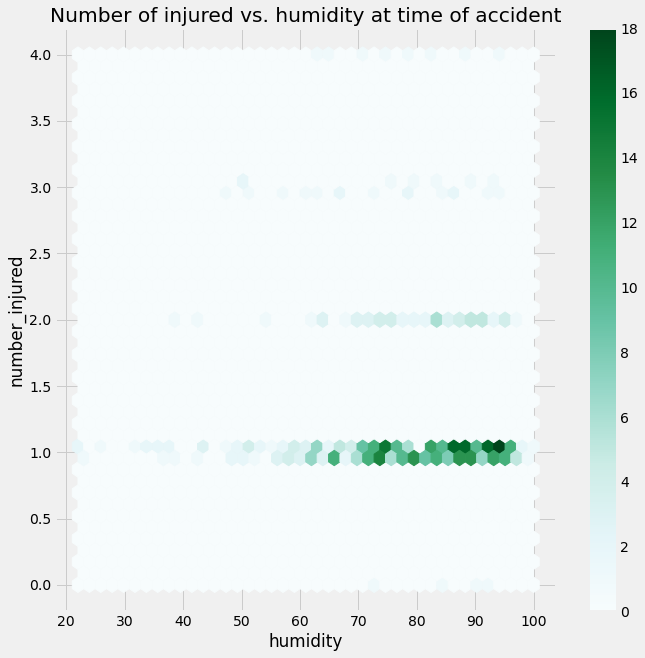

In [265]:
clean_df.plot(kind='hexbin', x='humidity', y='number_injured', gridsize=40,figsize=(10,10))
plt.title("Number of injured vs. humidity at time of accident")

### Categorical Data Analysis

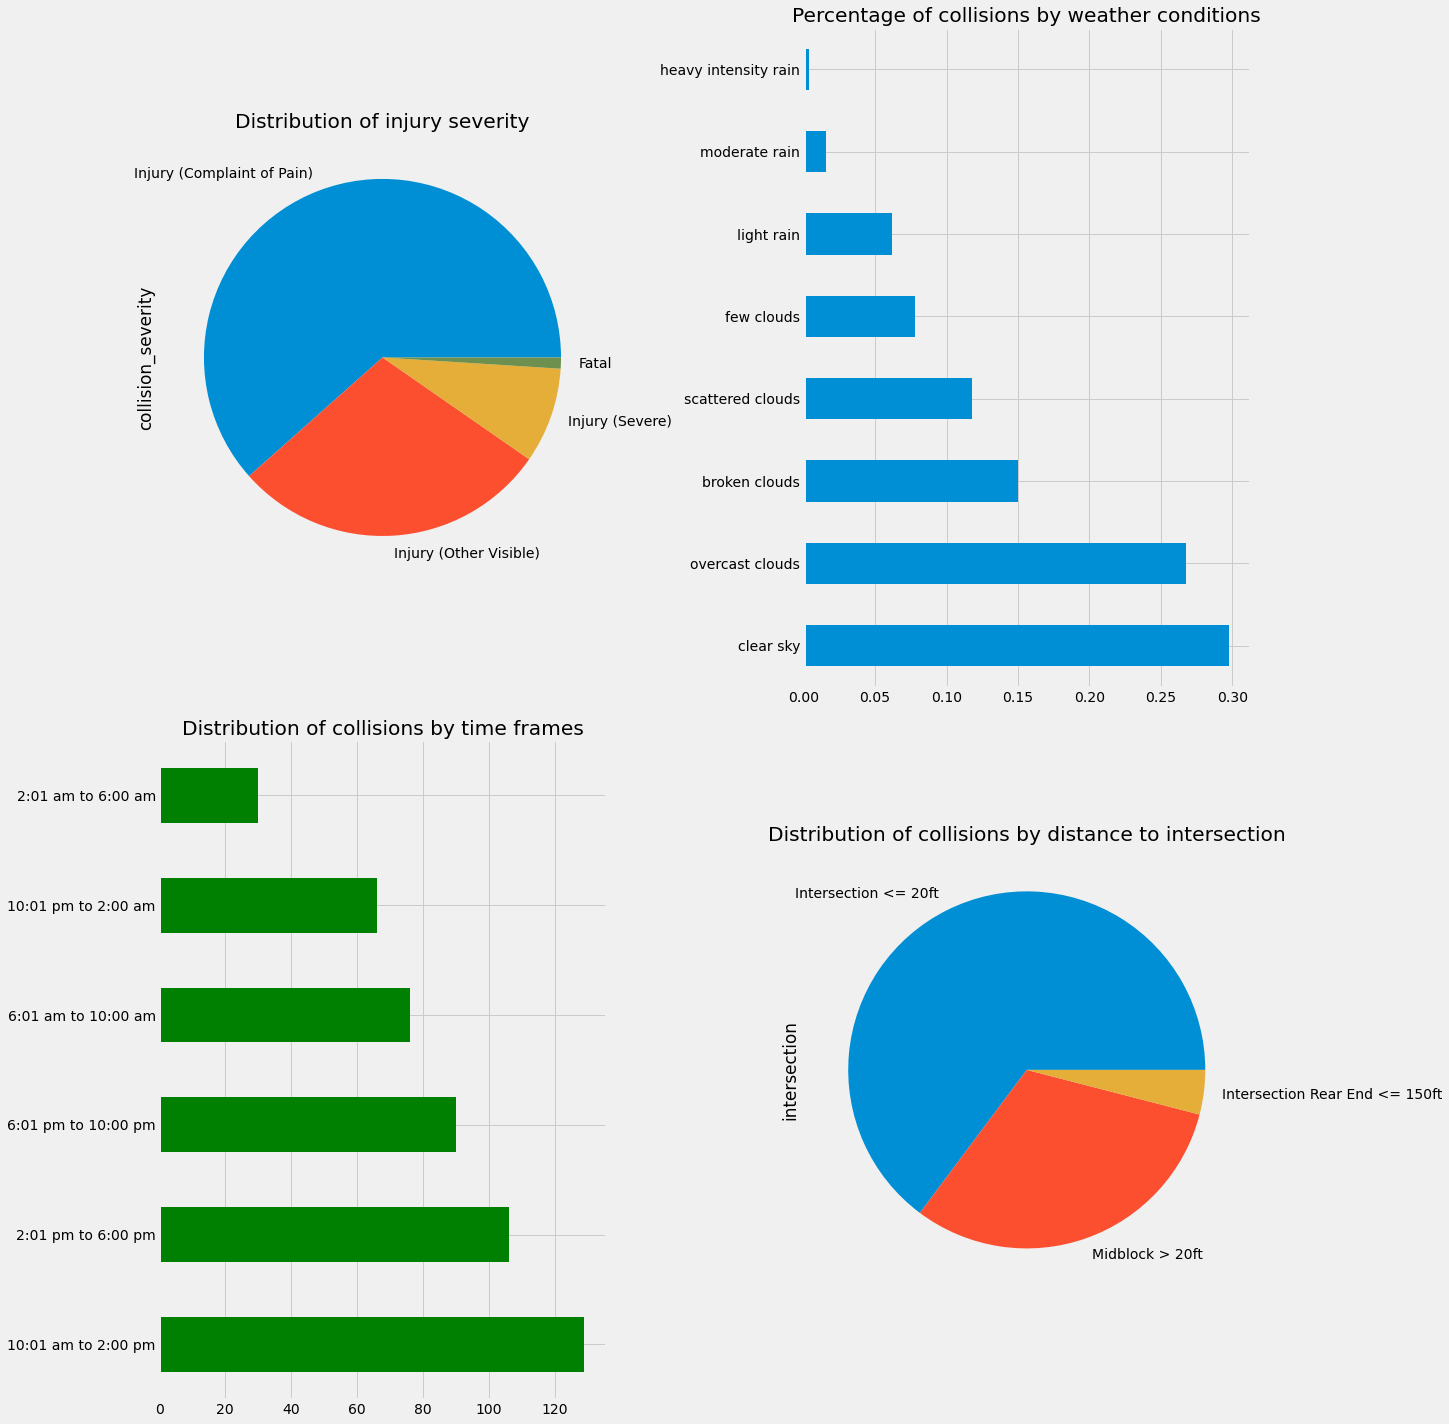

In [269]:
fig = plt.figure(figsize=(20,20))

# Create the first subfigure
sub1 = fig.add_subplot(2,2,1)
clean_df["collision_severity"].value_counts().plot(kind='pie')
plt.title("Distribution of injury severity")

# Create the second subfigure
sub2 = fig.add_subplot(2,2,2)
graph1 = clean_df['description'].value_counts()/len(merged1)
graph1.plot(kind = 'barh')
plt.title("Percentage of collisions by weather conditions")

# Create the third subfigure
sub3 = fig.add_subplot(2,2,3)
clean_df["time_cat"].value_counts().plot(kind='barh',
                                    color='green')
plt.title("Distribution of collisions by time frames")

# Create the fourth subfigure
sub4 = fig.add_subplot(2,2,4)
clean_df['intersection'].value_counts().plot(kind = 'pie')
plt.title("Distribution of collisions by distance to intersection")

plt.tight_layout()



<AxesSubplot:title={'center':'temp'}, xlabel='accident_year'>

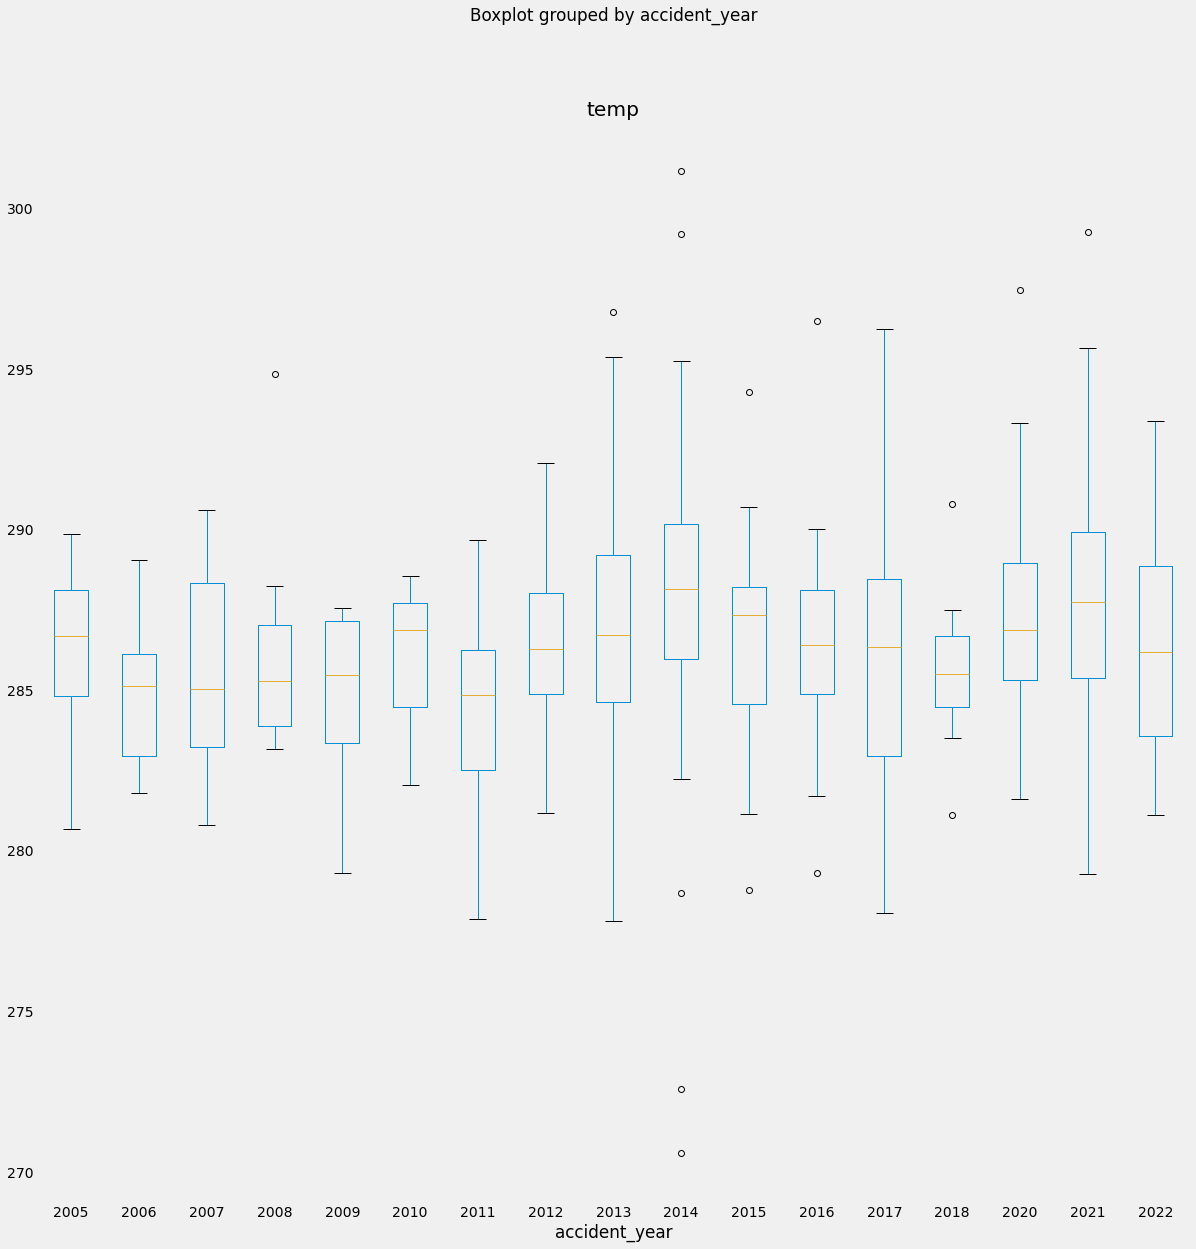

In [270]:
clean_df.boxplot(column='temp', by='accident_year', grid=False, figsize = (20,20))

<AxesSubplot:ylabel='mviw,main'>

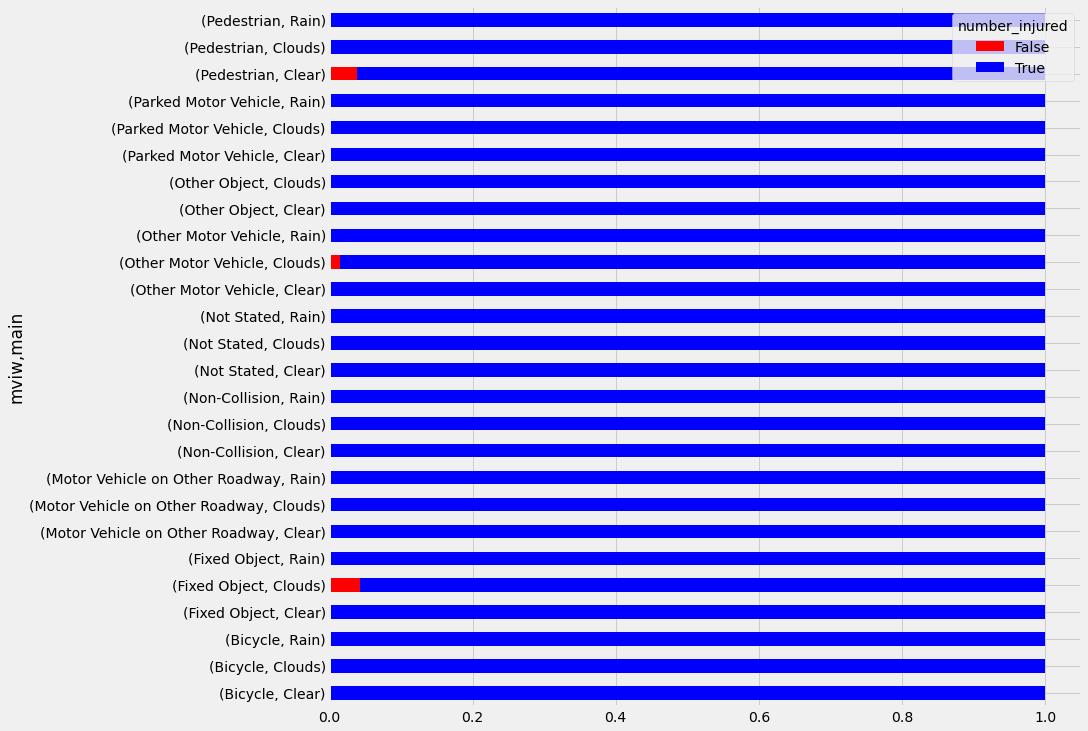

In [271]:
death_counts = pd.crosstab([clean_df.mviw, clean_df.main], clean_df.number_injured.astype(bool))
death_counts.div(death_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['red','blue'])


Text(0.5, 1.0, 'Top 5 secondary streets by accidents')

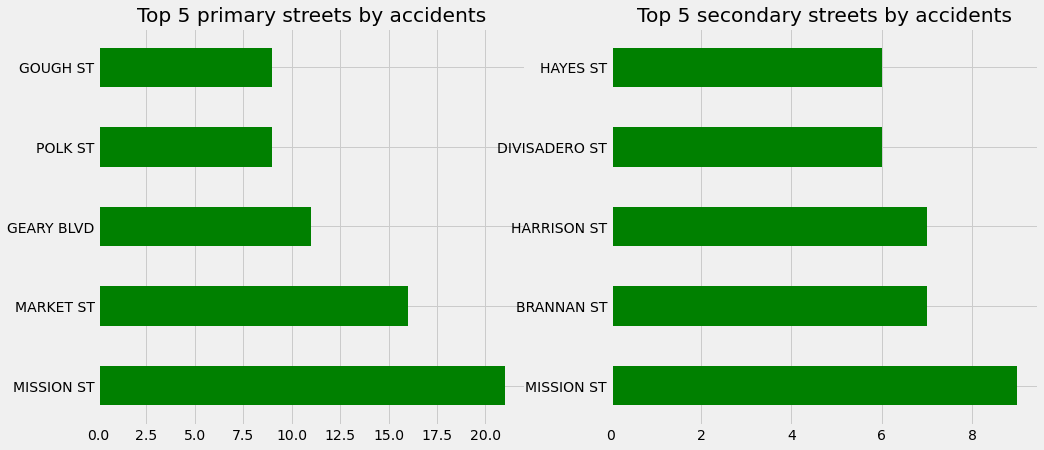

In [273]:
#top 10 streets by accidents
fig = plt.figure(figsize=(15,15))

# Create the first subfigure
sub1 = fig.add_subplot(2,2,1)
clean_df['primary_rd'].value_counts()[:5].plot(kind = 'barh',color = 'green')
plt.title("Top 5 primary streets by accidents")

# Create the second subfigure
sub2 = fig.add_subplot(2,2,2)
clean_df['secondary_rd'].value_counts()[:5].plot(kind = 'barh',color = 'green')
plt.title("Top 5 secondary streets by accidents")

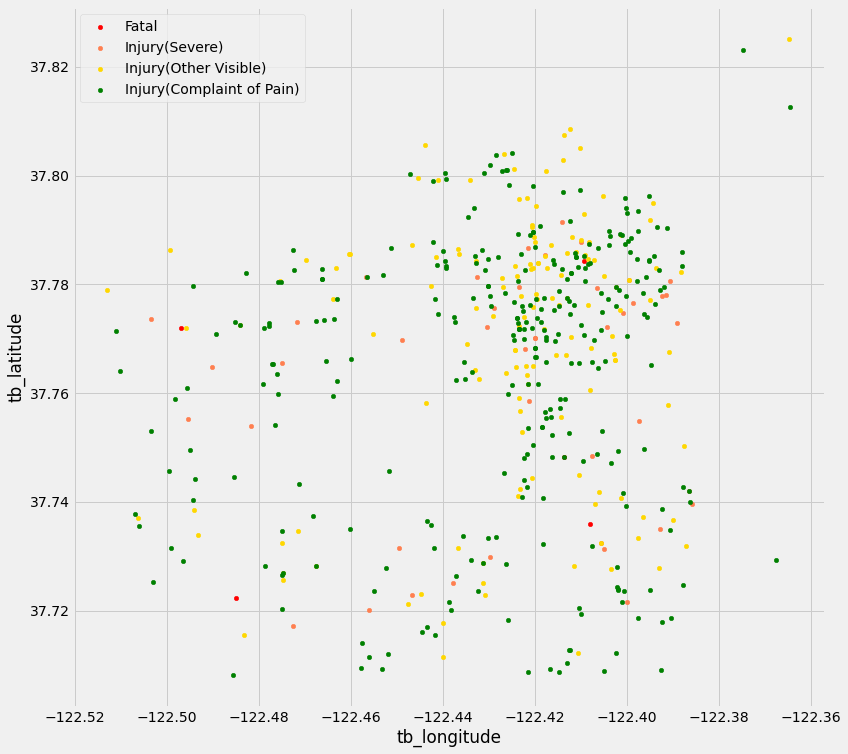

In [274]:
plt.rcParams['figure.figsize'] = (12, 12)

fatal = (clean_df["collision_severity"] == 'Fatal')
severe = (clean_df["collision_severity"] == 'Injury (Severe)')
other_visible = (clean_df["collision_severity"] == 'Injury (Other Visible)')
pain = (clean_df["collision_severity"] == 'Injury (Complaint of Pain)')


firstplot = clean_df[fatal].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='red', 
                label='Fatal')

secondplot = clean_df[severe].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='coral', 
                label='Injury(Severe)',
                ax = firstplot)

thirdplot = clean_df[other_visible].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='Gold', 
                label='Injury(Other Visible)',
                ax = firstplot)

fourthplot = clean_df[pain].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='Green', 
                label='Injury(Complaint of Pain)',
                ax = firstplot)

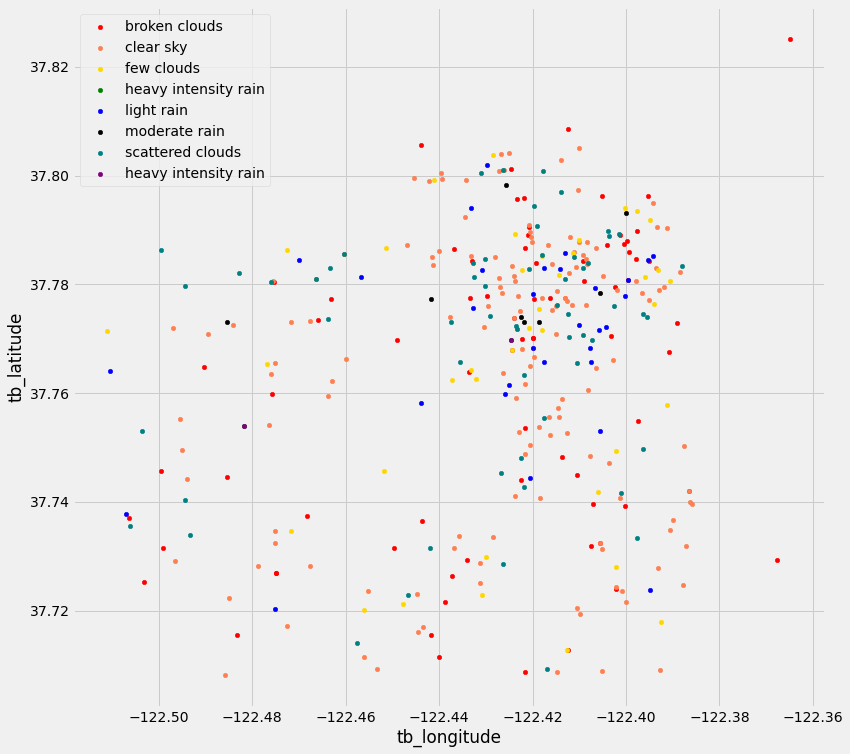

In [275]:
plt.rcParams['figure.figsize'] = (12, 12)

broken_clouds = (clean_df["description"] == 'broken clouds')
clear_sky = (clean_df["description"] == 'clear sky')
few_clouds = (clean_df["description"] == 'few clouds')
heavy_rain = (clean_df["description"] == 'heavy intensity rain')
light_rain = (clean_df["description"] == 'light rain')
moderate_rain = (clean_df["description"] == 'moderate rain')
overcast_clouds = (clean_df["description"] == 'overcast clouds')
scattered_clouds = (clean_df["description"] == 'scattered clouds')

firstplot = clean_df[broken_clouds].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='red', 
                label='broken clouds')

secondplot = clean_df[clear_sky].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='coral', 
                label='clear sky',
                ax = firstplot)

thirdplot = clean_df[few_clouds].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='Gold', 
                label='few clouds',
                ax = firstplot)

fourthplot = clean_df[heavy_rain].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='Green', 
                label='heavy intensity rain',
                ax = firstplot)

fifthplot = clean_df[light_rain].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='blue', 
                label='light rain',
                ax = firstplot)

sixthplot = clean_df[moderate_rain].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='black', 
                label='moderate rain',
                ax = firstplot)

seventhplot = clean_df[scattered_clouds].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='teal', 
                label='scattered clouds',
                ax = firstplot)

eigthplot = clean_df[heavy_rain].plot(kind='scatter', 
                x='tb_longitude', 
                y='tb_latitude', 
                color='purple', 
                label='heavy intensity rain',
                ax = firstplot)